# CMPUT 466/566, Winter 2020 Introduction to Machine learning 
## Coding Assignment 2 
### Problem 1 Report
By Nathan Klapstein #1449872

In [32]:

import struct

import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.sparse


In [33]:
# sometimes despite our best efforts we will get a overflow
# Note: this was only observed on using getAccuracy on the test sets, 
# this is likey just a fault of doing a summation of exponents with a
# large number of datapoints.
# Note: these errors never occured during actual training, thus, were
# assumed to be anomaly with using the test data.
np.seterr(divide='ignore', invalid='ignore', over='ignore')


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

Load in the MNIST data for later compute.

In [34]:

def readMNISTdata():
    with open('data/t10k-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows * ncols))

    with open('data/t10k-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size, 1))

    with open('data/train-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows * ncols))

    with open('data/train-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size, 1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate(
        (np.ones([train_data.shape[0], 1]), train_data), axis=1)
    test_data = np.concatenate((np.ones([test_data.shape[0], 1]), test_data),
                               axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val = train_data[50000:] / 256
    t_val = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()

print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)


(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)


Various global configurations.

In [43]:
# ten numbers to classify: 0,1,2,3,4,5,6,7,8,9
N_class = 10

# original defined hyper parameters
# alpha = 0.1  # learning rate
# batch_size = 100  # batch size
# MaxIter = 50  # Maximum iteration
# decay = 0.  # weight decay

# original hyperparameters for the first expiremental run
alpha = 0.1  # learning rate
num_batches = 500
batch_size = 50000 // num_batches 
MaxIter = 50  # Maximum iteration
decay = 0.0  # weight decay
lam =  0.00000003  # regularization loss multiplier


# spam stdout with our ML models training progress
verbose = True

In [44]:

def oneHotIt(Y):
    """Convert unidimensional array of labels into a one-hot variant
    where the array is size m (examples) x n (classes)."""
    m = Y.shape[0]
    Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


def softmax(z):
    z -= np.max(z) + np.min(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm


def getLoss(w, x, y):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam / 2) * np.sum(w * w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam * w #And compute the gradient for that loss
    return loss, grad


def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX, w))
    preds = np.argmax(probs, axis=1)
    return probs, preds


# inspired by https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
def getAccuracy(someX, someY, w):
    prob, prede = getProbsAndPreds(someX,w)
    someY = someY.flatten()
    num_correct = np.sum(prede == someY)
    num_incorrect = np.sum(prede != someY)
    accuracy = num_correct / (num_correct + num_incorrect)
    return accuracy, num_correct, num_incorrect


def predict(x, w, t=None):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    
    # TODO Your code here
    y = np.matmul(x, w)
    
    t_hat = np.argmax(y, axis=1)
    
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(t) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam / 2) * np.sum(w * w) # compute the loss
    
    # compute the mean-per class accuracy
    acc = getAccuracy(x, t, w)
    
    return y, t_hat, loss, acc


def train(X_train, t_train, X_val, t_val):
    N_train = X_train.shape[0]
    N_val = X_val.shape[0]

    # TODO Your code here
    
    # initialization
    w = np.zeros([X_train.shape[1], N_class])
    # w: (d+1)x1

    losses_train = []
    acc_val = []
    w_best = None
    acc_best = 0
    epoch_best = 0
    
    print(f"running {int(np.ceil(N_train / batch_size))} batches of size {batch_size} over data size {X_train.shape[0]} for {MaxIter} epochs")
    for epoch in range(MaxIter):
        loss_this_epoch = 0
        for b in range(int(np.ceil(N_train / batch_size))):
            X_batch = X_train[b * batch_size: (b + 1) * batch_size]
            t_batch = t_train[b * batch_size: (b + 1) * batch_size]
            loss_batch, grad = getLoss(w, X_batch, t_batch)
            loss_this_epoch += loss_batch
            
            # gradient decent with simple weight decay
            w = w - (alpha * grad) - (alpha * decay * w)
        # TODO: Your code here
        # monitor model behavior after each epoch
        
        # 1. Compute the training loss by averaging loss_this_epoch    
        loss_this_epoch = loss_this_epoch / (int(np.ceil(N_train/batch_size)))
        val_acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, w)
        if verbose:
            print(f"epoch {epoch:>3}/{MaxIter:<2} loss:{loss_this_epoch:.18f} val_acc:{val_acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
        losses_train.append(loss_this_epoch)

        # 2. Perform validation on the validation test by the risk
        # TODO: FIXED: Validation set should not be run in batches
        acc_val.append(val_acc)
        
        # 3. Keep track of the best validation epoch, risk, and the weights
        if acc_val[epoch] >= acc_best:
            epoch_best = epoch
            acc_best = acc_val[epoch]
            w_best = w

    # Return some variables as needed
    return epoch_best, losses_train, acc_val, acc_best, w_best


def plot_training_losses(losses_train):
    fig = plt.figure()
    plt.plot(losses_train, label="Training Losses")
    plt.title("Training Losses\n{}".format(f"alpha={alpha} num_batches={num_batches} batch_size={batch_size} MaxIter={MaxIter} decay={decay} lam={lam}"))
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Training Loss')
    plt.show()
    
    
def plot_training_accuracy(acc_val):
    fig = plt.figure()
    plt.plot(acc_val, label="Validation Accuracy")
    plt.title("Validation Accuracy\n{}".format(f"alpha={alpha} num_batches={num_batches} batch_size={batch_size} MaxIter={MaxIter} decay={decay} lam={lam}"))
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
    

In [45]:
# training the model
epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)

running 500 batches of size 100 over data size 50000 for 50 epochs
epoch   0/50 loss:0.566486243970208192 val_acc:0.890400 correct|incorrect:8904|1096
epoch   1/50 loss:0.374267819457150985 val_acc:0.899100 correct|incorrect:8991|1009
epoch   2/50 loss:0.344192552050699652 val_acc:0.903100 correct|incorrect:9031|969
epoch   3/50 loss:0.328632189112471051 val_acc:0.906700 correct|incorrect:9067|933
epoch   4/50 loss:0.318617322573596873 val_acc:0.909300 correct|incorrect:9093|907
epoch   5/50 loss:0.311435600191826256 val_acc:0.910900 correct|incorrect:9109|891
epoch   6/50 loss:0.305933380125655796 val_acc:0.912200 correct|incorrect:9122|878
epoch   7/50 loss:0.301523825989891747 val_acc:0.913500 correct|incorrect:9135|865
epoch   8/50 loss:0.297872735350642182 val_acc:0.914300 correct|incorrect:9143|857
epoch   9/50 loss:0.294774143781366238 val_acc:0.914400 correct|incorrect:9144|856
epoch  10/50 loss:0.292093396358682478 val_acc:0.914300 correct|incorrect:9143|857
epoch  11/50 loss:

The best epoch and its respective validation and test accuracies are shown below:

In [46]:
print(f"best epoch: {epoch_best}")
acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, W_best)
print(f"val_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
acc, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
print(f"tst_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")

best epoch: 49
val_acc:0.919000 correct|incorrect:9190|810
tst_acc:0.268900 correct|incorrect:2689|7311


Noteably, we have obtained a great validation accuracy 90%! But, have also obtained a horrible test accuracy of 0.26%!. We might be overfitting in this case.

The learning curve of the training loss, where x-axis is the number of epochs,
and y-axis is the training loss.

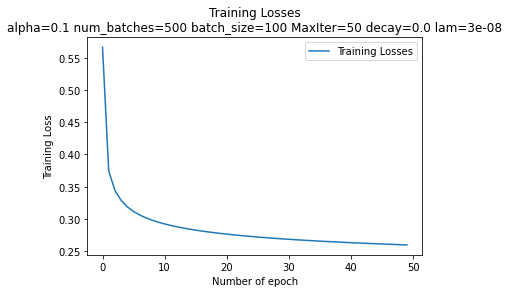

In [47]:
plot_training_losses(losses_train)

The accuracy curve, where x-axis is the number of epochs, and y-axis is the 
accuracy in decimal form (0.0-1.0).

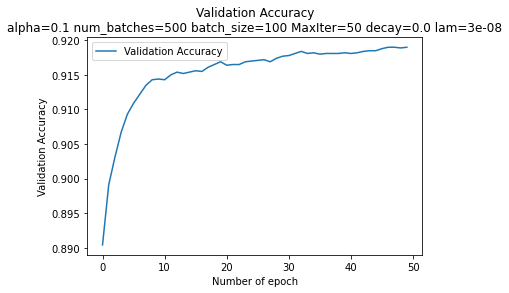

In [48]:
plot_training_accuracy(acc_val)

Getting accuracy of the learned model on the various data sets 
(train, validation, test).

In [41]:
acc, num_correct, num_incorrect = getAccuracy(X_train, t_train, W_best)
print(f"trn_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, W_best)
print(f"val_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
acc, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
print(f"tst_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")


trn_acc:0.929360 correct|incorrect:46468|3532
val_acc:0.919000 correct|incorrect:9190|810
tst_acc:0.268900 correct|incorrect:2689|7311


### Problem 2 Report

Ask one meaningful scientific question yourself, design your experimental 
protocol, present results, and draw a conclusion.  

#### Scientific Question

With proper tuning of the hyperparameters:

* Can we obtain a higher accuracy than 81-83% on the validation and test sets?

* Can we obtain a higher accuracy with less iterations with proper 
    hyperparameter tuning?

#### Experimental Protocol

Re-run the experiment (training the model with the MNIST data) and tuning the 
models hyperparameters for the best perceived validation and test accuracies. 

The goal is to obtain the best validation accuracy, that still upholds an 
acceptable test accuracy.

The following hyperparameters will be tuned across the experiment:

* ``alpha`` - learning rate
* ``num_batches`` - number of batches
* ``batch_size`` - size of batches
* ``MaxIter`` - number of epochs
* ``decay`` - weight decay
* ``lam`` - regularization loss multiplier

#### Experimental Results

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.1 num_batches=10 batch_size=5000 MaxIter=50 decay=0.01 lam=0.04
running 10 batches of size 5000 over data size 50000 for 50 epochs


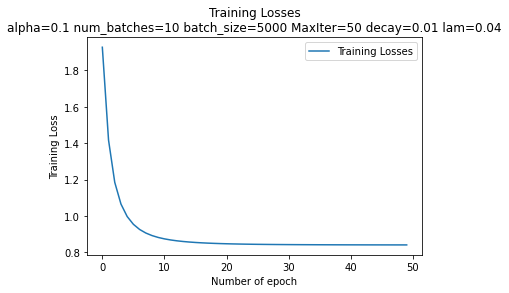

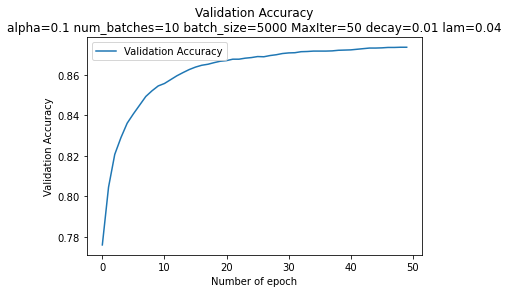

trn_acc:0.873720 correct|incorrect:43686|6314
val_acc:0.873600 correct|incorrect:8736|1264
tst_acc:0.881500 correct|incorrect:8815|1185

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.3 num_batches=10 batch_size=5000 MaxIter=100 decay=0.002 lam=3e-08
running 10 batches of size 5000 over data size 50000 for 100 epochs


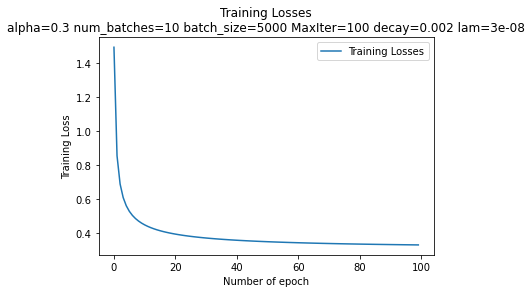

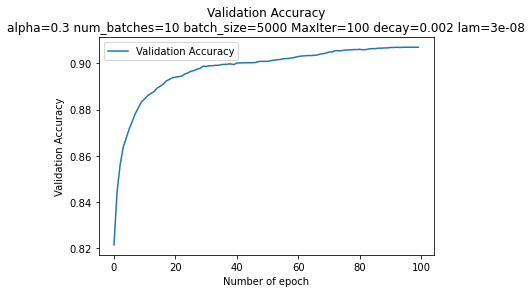

trn_acc:0.912060 correct|incorrect:45603|4397
val_acc:0.906900 correct|incorrect:9069|931
tst_acc:0.793300 correct|incorrect:7933|2067

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.4 num_batches=20 batch_size=2500 MaxIter=100 decay=0.0025 lam=3e-08
running 20 batches of size 2500 over data size 50000 for 100 epochs


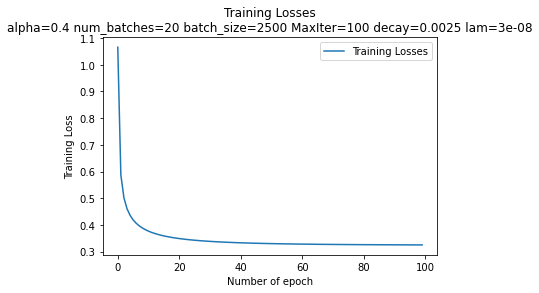

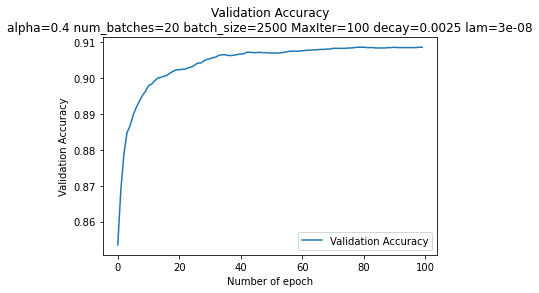

trn_acc:0.914320 correct|incorrect:45716|4284
val_acc:0.908600 correct|incorrect:9086|914
tst_acc:0.790500 correct|incorrect:7905|2095

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.3 num_batches=10 batch_size=5000 MaxIter=100 decay=0.002 lam=3e-08
running 10 batches of size 5000 over data size 50000 for 100 epochs


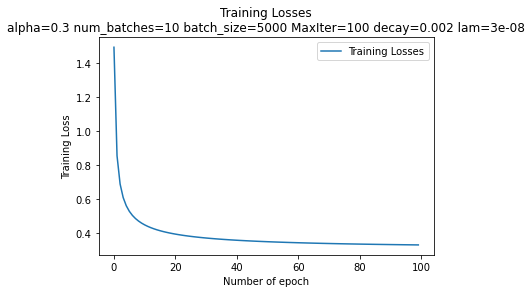

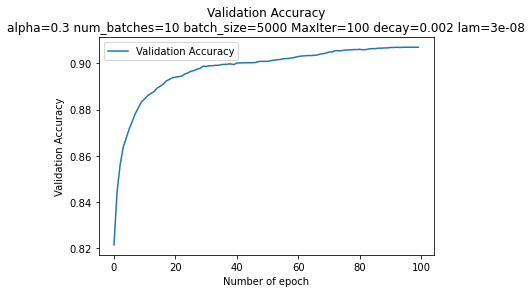

trn_acc:0.912060 correct|incorrect:45603|4397
val_acc:0.906900 correct|incorrect:9069|931
tst_acc:0.793300 correct|incorrect:7933|2067

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.36 num_batches=10 batch_size=5000 MaxIter=50 decay=0.014 lam=3e-08
running 10 batches of size 5000 over data size 50000 for 50 epochs


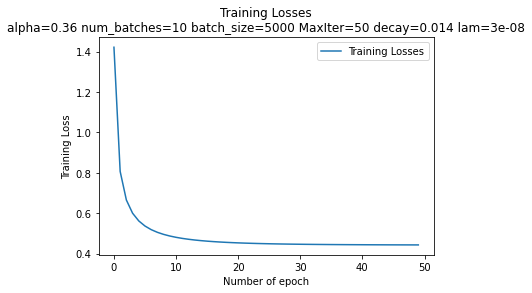

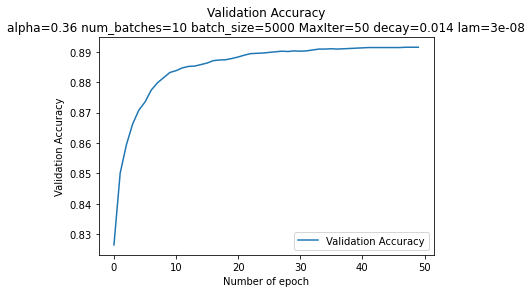

trn_acc:0.894380 correct|incorrect:44719|5281
val_acc:0.891500 correct|incorrect:8915|1085
tst_acc:0.894400 correct|incorrect:8944|1056

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.37 num_batches=16 batch_size=3125 MaxIter=200 decay=0.01 lam=3e-08
running 16 batches of size 3125 over data size 50000 for 200 epochs


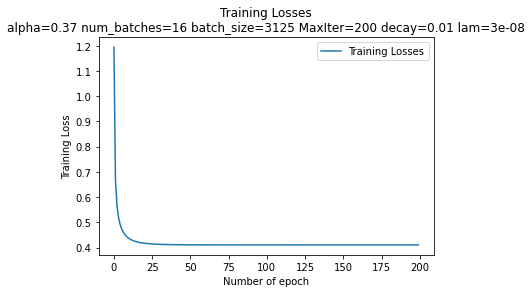

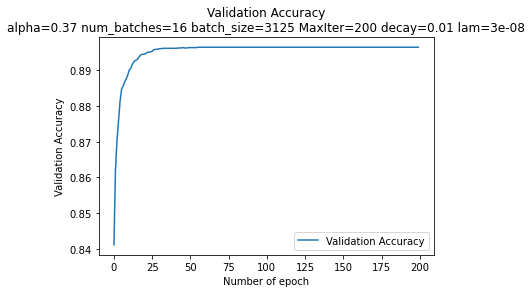

trn_acc:0.899320 correct|incorrect:44966|5034
val_acc:0.896500 correct|incorrect:8965|1035
tst_acc:0.892700 correct|incorrect:8927|1073

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.37 num_batches=16 batch_size=3125 MaxIter=75 decay=0.01 lam=3e-08
running 16 batches of size 3125 over data size 50000 for 75 epochs


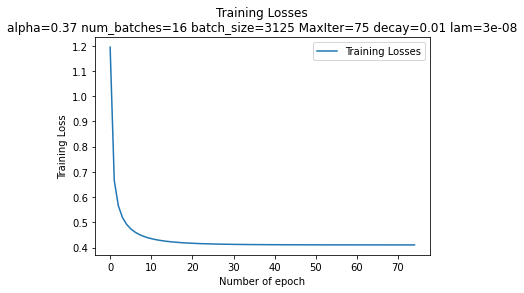

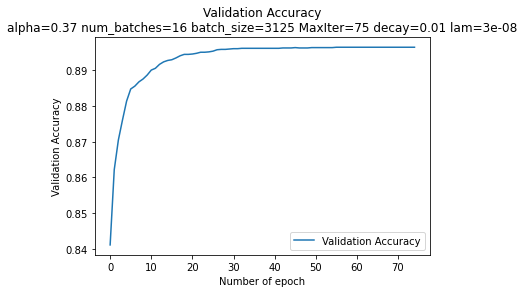

trn_acc:0.899320 correct|incorrect:44966|5034
val_acc:0.896500 correct|incorrect:8965|1035
tst_acc:0.892700 correct|incorrect:8927|1073

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.4 num_batches=16 batch_size=3125 MaxIter=30 decay=0.01 lam=3e-08
running 16 batches of size 3125 over data size 50000 for 30 epochs


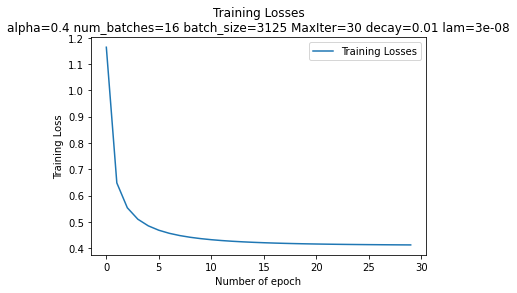

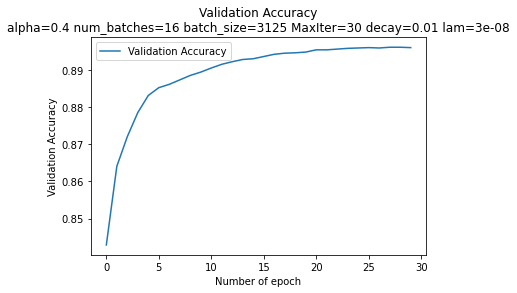

trn_acc:0.898560 correct|incorrect:44928|5072
val_acc:0.896200 correct|incorrect:8962|1038
tst_acc:0.891500 correct|incorrect:8915|1085

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
alpha=0.5 num_batches=16 batch_size=3125 MaxIter=30 decay=0.01 lam=3e-08
running 16 batches of size 3125 over data size 50000 for 30 epochs


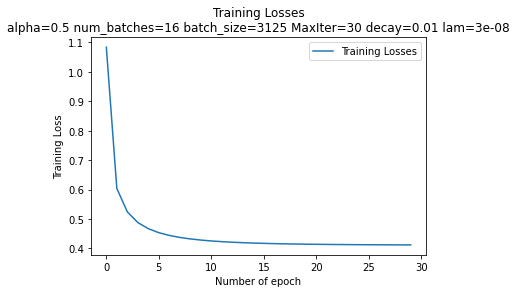

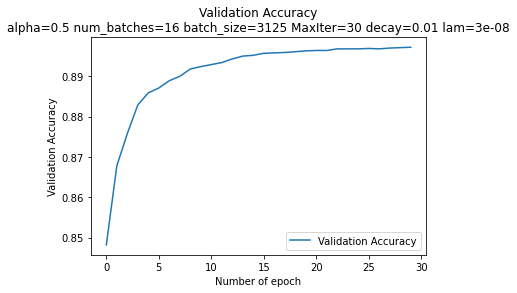

trn_acc:0.898900 correct|incorrect:44945|5055
val_acc:0.897200 correct|incorrect:8972|1028
tst_acc:0.891500 correct|incorrect:8915|1085



In [42]:

# don't spam stdout
verbose = False

hyperparameter_tests = [
    {  # 88 test accuracy
        "alpha": 0.1,
        "num_batches": 10,
        "MaxIter": 50,
        "decay": 0.01,
        "lam": 0.04
    },   
    { # 89.25 test accuracy
        "alpha": 0.3,
        "num_batches": 10,
        "MaxIter": 100,
        "decay": 0.002,
        "lam": 0.00000003
    }, 
    {
        "alpha": 0.4,
        "num_batches": 20,
        "MaxIter": 100,
        "decay": 0.0025,
        "lam": 0.00000003
    },   
    { # feels like over fitting
        "alpha": 0.3,
        "num_batches": 10,
        "MaxIter": 100,
        "decay": 0.002,
        "lam": 0.00000003
    }, 
    {
        "alpha": 0.36,
        "num_batches": 10,
        "MaxIter": 50,
        "decay": 0.014,
        "lam": 0.00000003
    },    
    {
        "alpha": 0.37,
        "num_batches": 16,
        "MaxIter": 200,
        "decay": 0.01,
        "lam": 0.00000003
    },
    {
        "alpha": 0.37,
        "num_batches": 16,
        "MaxIter": 75,
        "decay": 0.01,
        "lam": 0.00000003
    },
    {
        "alpha": 0.4,
        "num_batches": 16,
        "MaxIter": 30,
        "decay": 0.01,
        "lam": 0.00000003
    },
    { # subjectively best performance
        "alpha": 0.5,
        "num_batches": 16,
        "MaxIter": 30,
        "decay": 0.01,
        "lam": 0.00000003
    }
]


for hyperparameter_dict in hyperparameter_tests:
    # reload the MNIST data to be safe
    X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()
    print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)
    
    alpha = hyperparameter_dict["alpha"]
    num_batches = hyperparameter_dict["num_batches"]
    batch_size = 50000 // num_batches
    MaxIter = hyperparameter_dict["MaxIter"]
    decay = hyperparameter_dict["decay"]
    lam = hyperparameter_dict["lam"]
    
    print(f"alpha={alpha} num_batches={num_batches} batch_size={batch_size} MaxIter={MaxIter} decay={decay} lam={lam}")
    
    epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)
    plot_training_losses(losses_train)
    plot_training_accuracy(acc_val)
    
    acc, num_correct, num_incorrect = getAccuracy(X_train, t_train, W_best)
    print(f"trn_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
    acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, W_best)
    print(f"val_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
    acc, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
    print(f"tst_acc:{acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
    print()

#### Conclusion

Despite my primitive hyperparameter tuning method, tuning the hyperparameters 
as shown within the experimental results noted a increase in validation and 
test accuracy from ~82% to ~89%.

The final tuned hyperparameters I would recommend using for a production 
deployment of this ML model would be the following:

* ``alpha=0.5`` - learning rate
* ``num_batches=16`` - number of batches
* ``batch_size=3125`` - size of batches
* ``MaxIter=30`` - number of epochs
* ``decay=0.01`` - weight decay
* ``lam=0.00000003`` - regularization loss multiplier

Also we were able to optimize the number of iterations from 50 to 30 without 
losing much accuracy. This was possible by increasing the learning rate from
``alpha=0.1`` to ``alpha=0.5`` and by visual inspection of the validation 
accuracy graphs showning that the logrithmic curve was still not appoaching 
its limit.

One take away from this expirement is how useful the training losses and 
validation accuracy plots were for addressing potential issues with the 
training of the model. I wonder if there is any other methods for visualizing 
the training of ML models that could help assist in human fine-tining and 
troubleshooting of said models.
